In [ ]:
import os

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [ ]:
os.chdir("./")

In [ ]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
bts = pd.read_csv('./input/bus_bts.csv')

In [ ]:
#check the numbers of samples and features
print("The train data size is : {} ".format(train.shape))
print("The test data size is : {} ".format(test.shape))
print("The bts data size is : {} ".format(test.shape))

The train data size is : (415423, 21) 
The test data size is : (228170, 20) 
The bts data size is : (228170, 20) 


### takeoff_tag : 하차태그 유무 컬럼
- 1: tag 함
- 0: tag 안함

In [ ]:
bts.loc[bts["getoff_date"].isnull()==True,'takeoff_tag']=0
bts.loc[bts["getoff_date"].isnull()==False,'takeoff_tag']=1

In [ ]:
gr_getoff_tag = bts.groupby(['geton_date','bus_route_id', 'geton_station_code','takeoff_tag'])['takeoff_tag'].count()

In [ ]:
# series->df
gr_getoff_tag.to_csv("gr_getofftag.csv")
tag_getoff=pd.read_csv("gr_getofftag.csv",header=None)
# tag_getoff.head()

In [ ]:
cols= ['date','bus_route_id','station_code','takeoff_tag', 'cnt_tag']
tag_getoff.columns = cols

In [ ]:
# user_category: mapping
tag_getoff['takeoff_tag'] = tag_getoff['takeoff_tag'].map({1:'takeoff_tag_yes', 0:'takeoff_tag_no'})

In [ ]:
# cast = pivot
ind_cast = ['date','bus_route_id','station_code']
tag_getoff = pd.pivot_table(tag_getoff,index=ind_cast,columns='takeoff_tag', values='cnt_tag')
type(tag_getoff)

pandas.core.frame.DataFrame

### get on total grouping

In [ ]:
bts = pd.read_csv('./input/bus_bts.csv')

In [ ]:
gr_geton = bts.groupby(['geton_date','bus_route_id', 'geton_station_code','user_category'])['user_category'].count()

In [ ]:
# s->df
gr_geton.to_csv("gr_geton.csv")
cate_geton=pd.read_csv("gr_geton.csv",header=None)

In [ ]:
# df -> column 생성
cols= ['date','bus_route_id','station_code','user_category', 'cnt_cate']
cate_geton.columns = cols
cate_geton

,date,bus_route_id,station_code,user_category,cnt_cate
0,2019-09-01,4270000,344,1,15
1,2019-09-01,4270000,344,2,1
2,2019-09-01,4270000,357,1,22
3,2019-09-01,4270000,432,1,4
4,2019-09-01,4270000,1579,1,79
...,...,...,...,...,...
861559,2019-10-16,32790000,3372,1,3
861560,2019-10-16,32820000,28,1,3
861561,2019-10-16,32820000,1129,1,2
861562,2019-10-16,32820000,1129,4,1


In [ ]:
# user_category: mapping
cate_geton['user_category'] = cate_geton['user_category'].map({1:'ride_normal', 2:'ride_child', 4:'ride_teen', 6:'ride_senior', 27:'ride_disabled_normal', 28:'ride_disabled_accompanied', 29:'ride_merit_normal', 30:'ride_merit_accompanied'})
cate_geton

,date,bus_route_id,station_code,user_category,cnt_cate
0,2019-09-01,4270000,344,ride_normal,15
1,2019-09-01,4270000,344,ride_child,1
2,2019-09-01,4270000,357,ride_normal,22
3,2019-09-01,4270000,432,ride_normal,4
4,2019-09-01,4270000,1579,ride_normal,79
...,...,...,...,...,...
861559,2019-10-16,32790000,3372,ride_normal,3
861560,2019-10-16,32820000,28,ride_normal,3
861561,2019-10-16,32820000,1129,ride_normal,2
861562,2019-10-16,32820000,1129,ride_teen,1


In [ ]:
# cast = pivot
ind_cast = ['date','bus_route_id','station_code']
cate_geton = pd.pivot_table(cate_geton,index=ind_cast, columns='user_category', values='cnt_cate')

In [ ]:
# geton_usercategory + takeoff_tag
on_cate_off_tag = pd.merge(cate_geton,tag_getoff, how = 'left', left_index = True, right_index=True)

In [ ]:
#missing
on_cate_off_tag = on_cate_off_tag.fillna(0)

In [ ]:
# on_cate_off_tag.isnull().sum()

## 2. Features engineering
### 1) target feature 분리

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
# y_train = train["18~20_ride"].values

all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data= train.append(test)

print("all_data size is : {}".format(all_data.shape))
all_data.shape,on_cate_off_tag.shape 

all_data size is : (643593, 21)


((643593, 21), (484386, 10))

### JOIN : all_data + cate_tag

In [ ]:
ind_cast = ['date','bus_route_id','station_code']
all_data=pd.merge(all_data, on_cate_off_tag, how='left', left_on=ind_cast, right_index=True).sort_values(by='id')
#all_data.join(on_cate_off_tag, on=ind_cast, how='left')

# all_data_cate=pd.merge(all_data,on_cate_off_tag, how='left', on=ind_cast)
#pd.concat([all_data,on_cate_off_tag], keys=ind_cast)

all_data.isnull().sum()

10~11_ride                        0
10~11_takeoff                     0
11~12_ride                        0
11~12_takeoff                     0
18~20_ride                   228170
6~7_ride                          0
6~7_takeoff                       0
7~8_ride                          0
7~8_takeoff                       0
8~9_ride                          0
8~9_takeoff                       0
9~10_ride                         0
9~10_takeoff                      0
bus_route_id                      0
date                              0
id                                0
in_out                            0
latitude                          0
longitude                         0
station_code                      0
station_name                      0
ride_child                   159207
ride_disabled_accompanied    159207
ride_disabled_normal         159207
ride_merit_accompanied       159207
ride_merit_normal            159207
ride_normal                  159207
ride_senior                 

### 2) missing data 처리

In [ ]:
# # ind test- trin 조정

# ind = all_data[(all_data_cate['18~20_ride'].isnull()==True) & (all_data_cate['ride_child'].isnull()==True)].index
# ind

In [ ]:
# all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data.head(20)

In [ ]:
all_data[(all_data.isnull()==159207)].columns

Index(['10~11_ride', '10~11_takeoff', '11~12_ride', '11~12_takeoff',
       '18~20_ride', '6~7_ride', '6~7_takeoff', '7~8_ride', '7~8_takeoff',
       '8~9_ride', '8~9_takeoff', '9~10_ride', '9~10_takeoff', 'bus_route_id',
       'date', 'id', 'in_out', 'latitude', 'longitude', 'station_code',
       'station_name', 'ride_child', 'ride_disabled_accompanied',
       'ride_disabled_normal', 'ride_merit_accompanied', 'ride_merit_normal',
       'ride_normal', 'ride_senior', 'ride_teen', 'takeoff_tag_no',
       'takeoff_tag_yes'],
      dtype='object')

In [ ]:
ind = ['ride_child', 'ride_disabled_accompanied', 'ride_disabled_normal', 'ride_merit_accompanied', 'ride_merit_normal', 'ride_normal', 'ride_senior','ride_teen','takeoff_tag_no','takeoff_tag_yes' ]
for i in ind : 
    all_data[i].fillna(9999, inplace=True)
#     all_data[i] = all_data[i].astype('str')
    all_data[i][all_data[i]==9999]=all_data[i].mean()

In [ ]:
all_data.isnull().sum()

10~11_ride                        0
10~11_takeoff                     0
11~12_ride                        0
11~12_takeoff                     0
18~20_ride                   228170
6~7_ride                          0
6~7_takeoff                       0
7~8_ride                          0
7~8_takeoff                       0
8~9_ride                          0
8~9_takeoff                       0
9~10_ride                         0
9~10_takeoff                      0
bus_route_id                      0
date                              0
id                                0
in_out                            0
latitude                          0
longitude                         0
station_code                      0
station_name                      0
ride_child                        0
ride_disabled_accompanied         0
ride_disabled_normal              0
ride_merit_accompanied            0
ride_merit_normal                 0
ride_normal                       0
ride_senior                 

In [ ]:
y_train = train["18~20_ride"]
all_data.drop(['18~20_ride'], axis=1, inplace=True)

In [ ]:
all_data.isnull().sum()

10~11_ride                   0
10~11_takeoff                0
11~12_ride                   0
11~12_takeoff                0
6~7_ride                     0
6~7_takeoff                  0
7~8_ride                     0
7~8_takeoff                  0
8~9_ride                     0
8~9_takeoff                  0
9~10_ride                    0
9~10_takeoff                 0
bus_route_id                 0
date                         0
id                           0
in_out                       0
latitude                     0
longitude                    0
station_code                 0
station_name                 0
ride_child                   0
ride_disabled_accompanied    0
ride_disabled_normal         0
ride_merit_accompanied       0
ride_merit_normal            0
ride_normal                  0
ride_senior                  0
ride_teen                    0
takeoff_tag_no               0
takeoff_tag_yes              0
dtype: int64

* 외부데이터(기간: 2019.09.01 ~ 10.16)
* 06~11시에 해당되는 사항들만 편집

In [ ]:
#데이터 불러오기
raining=pd.read_csv("./input/exdata/20191203.csv",engine='python')

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,jeju,2019-09-01 0:00,23.7,NaN,2.0,180.0,67,1014.0,1016.4,NaN,NaN
1,jeju,2019-09-01 1:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
2,jeju,2019-09-01 2:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
3,jeju,2019-09-01 3:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
4,jeju,2019-09-01 4:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN


In [ ]:
# bts = pd.read_csv("./input/exdata/train_cate_onoff.csv",engine='python')
# bts.info()

### 3) Data Correlation

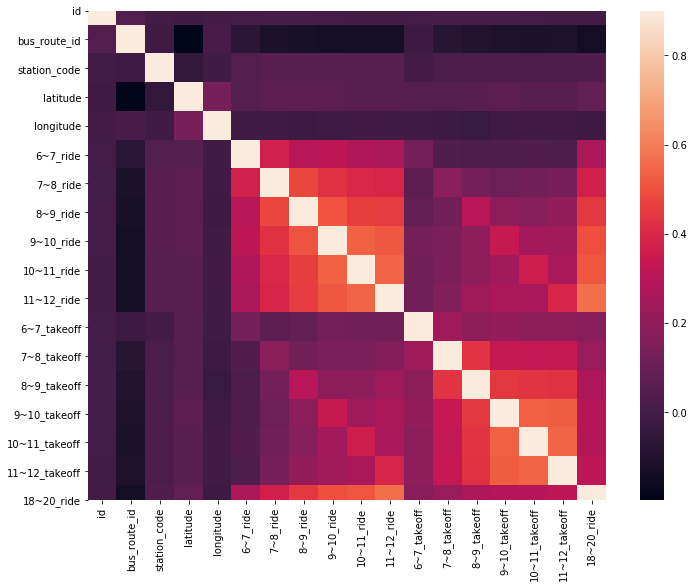

In [ ]:
#Correlation map to see how features are correlated with 18~20_ride
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
corrmat

,id,bus_route_id,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,1.000000,0.035830,-0.002053,-0.013783,-0.000816,0.000852,0.005181,0.007540,0.003844,-0.001189,-0.002990,0.002609,0.004733,0.008766,0.005899,0.002119,-0.000701,-0.000544
bus_route_id,0.035830,1.000000,-0.015897,-0.196758,0.010187,-0.070173,-0.119180,-0.127838,-0.137973,-0.129171,-0.129354,-0.019856,-0.081713,-0.102422,-0.114123,-0.116376,-0.111560,-0.143702
station_code,-0.002053,-0.015897,1.000000,-0.048951,-0.011303,0.036374,0.055432,0.057153,0.054709,0.050765,0.050141,-0.003185,0.020918,0.020559,0.022664,0.024277,0.025059,0.034360
latitude,-0.013783,-0.196758,-0.048951,1.000000,0.134208,0.045578,0.067125,0.066391,0.065680,0.059462,0.059777,0.050534,0.047558,0.055750,0.067264,0.058728,0.057602,0.079261
longitude,-0.000816,0.010187,-0.011303,0.134208,1.000000,-0.009556,-0.015767,-0.019433,-0.008536,-0.007532,-0.008551,-0.010856,-0.021163,-0.030240,-0.013897,-0.007629,-0.005170,-0.021368
6~7_ride,0.000852,-0.070173,0.036374,0.045578,-0.009556,1.000000,0.375844,0.296554,0.313622,0.279269,0.265106,0.131812,0.031980,0.019047,0.029102,0.030359,0.029797,0.262173
7~8_ride,0.005181,-0.119180,0.055432,0.067125,-0.015767,0.375844,1.000000,0.479535,0.427030,0.395135,0.389945,0.068717,0.184060,0.129881,0.106197,0.117298,0.135832,0.371751
8~9_ride,0.007540,-0.127838,0.057153,0.066391,-0.019433,0.296554,0.479535,1.000000,0.506296,0.458034,0.453017,0.085007,0.122234,0.303641,0.192257,0.175396,0.206125,0.445316
9~10_ride,0.003844,-0.137973,0.054709,0.065680,-0.008536,0.313622,0.427030,0.506296,1.000000,0.537374,0.517800,0.126445,0.144562,0.194736,0.339456,0.246237,0.241739,0.494085
10~11_ride,-0.001189,-0.129171,0.050765,0.059462,-0.007532,0.279269,0.395135,0.458034,0.537374,1.000000,0.542494,0.117809,0.144040,0.196125,0.241713,0.359848,0.268409,0.512666


### 4) Data Columns Classification

In [ ]:
# all_data.index

In [ ]:
# all_data.index.dtype

In [ ]:
# all_data.index.astype(np.float64, copy=False)

In [ ]:
# all_data.index.dtype

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643593 entries, 0 to 643592
Data columns (total 30 columns):
10~11_ride                   643593 non-null float64
10~11_takeoff                643593 non-null float64
11~12_ride                   643593 non-null float64
11~12_takeoff                643593 non-null float64
6~7_ride                     643593 non-null float64
6~7_takeoff                  643593 non-null float64
7~8_ride                     643593 non-null float64
7~8_takeoff                  643593 non-null float64
8~9_ride                     643593 non-null float64
8~9_takeoff                  643593 non-null float64
9~10_ride                    643593 non-null float64
9~10_takeoff                 643593 non-null float64
bus_route_id                 643593 non-null int64
date                         643593 non-null object
id                           643593 non-null int64
in_out                       643593 non-null object
latitude                     643593 non-null fl

In [ ]:
cate_feature = [col for col in all_data.columns if all_data[col].dtypes=="object"]
cate_feature=list(set(cate_feature))
num_feature = list(set(all_data.columns)-set(cate_feature))

In [ ]:
# cate_feature

In [ ]:
# num_feature

In [ ]:
# for i in cate_feature:
#     vals = set(all_data[i].values)
#     cnt = all_data[i].value_counts().sort_index(ascending=True)
#     print(i, "\n", cnt, "\n""\n")
# #     val_map = map({'cate_feature':i,'val':vals, 'val_cnt':len(vals)})

### 4)-A. categorical 변수

#### A-1. date 변수 변환

In [ ]:
all_data['date'] = pd.to_datetime(all_data['date'])

In [ ]:
all_data['weekday'] = all_data['date'].dt.weekday
# Monday is 0 and Sunday is 6.

In [ ]:
all_data = pd.get_dummies(all_data, columns=['weekday'])

In [ ]:
# ind = ['ride_child', 'ride_disabled_accompanied', 'ride_disabled_normal', 'ride_merit_accompanied', 'ride_merit_normal', 'ride_normal', 'ride_senior','ride_teen','takeoff_tag_no','takeoff_tag_yes' ]
# all_data = pd.get_dummies(all_data, columns=ind)

#### A-2. in_out 변수 변환

In [ ]:
# all_data['in_out'].value_counts()

In [ ]:
all_data['in_out'] = all_data['in_out'].map({'시내':0,'시외':1})

### 4)-B. numeric 변수

#### B-1. 승차, 하차시간: 승차, 하차 시간대 통합 작업

In [ ]:
all_data['68_ride']=all_data['6~7_ride']+all_data['7~8_ride'] # 6 ~ 8시 승차인원
all_data['810_ride']=all_data['8~9_ride']+all_data['9~10_ride']
all_data['1012_ride']=all_data['10~11_ride']+all_data['11~12_ride']

all_data['68_takeoff']=all_data['6~7_takeoff']+all_data['7~8_takeoff'] # 6 ~ 8시 하차인원
all_data['810_takeoff']=all_data['8~9_takeoff']+all_data['9~10_takeoff']
all_data['1012_takeoff']=all_data['10~11_takeoff']+all_data['11~12_takeoff']

all_data['ride']=all_data['68_ride']+all_data['810_ride']+all_data['1012_ride']
all_data['takeoff']=all_data['68_takeoff']+all_data['810_takeoff']+all_data['1012_takeoff']

In [ ]:
# train22=all_data[['6~7_ride', '7~8_ride', "8~9_ride", '9~10_ride', '10~11_ride', '11~12_ride', '68ride', "810_ride", "1012_ride"]]
# train22["ride"]=y_train

# cor=train22.corr()

In [ ]:
# cor

In [ ]:
# all_data.columns

* 차트로 target feature와의 상관관계 확인용 train 분리

In [ ]:
train = all_data[:ntrain] #ntrain = train.shape[0]
# test = all_data[ntrain:]

In [ ]:
# train22=train[['ride', 'takeoff']]
# train22["18~20_ride"]=y_train

# cor=train22.corr()
# # sns.set(style="white")
# # mask=np.zeros_like(cor,dtype=np.bool)
# # mask[np.triu_indices_from(mask)]=True

# # f,ax=plt.subplots(figsize=(20,15))
# # cmap=sns.diverging_palette(200,10,as_cmap=True)
# # sns.heatmap(cor, mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
# # plt.xticks(size=20)
# # plt.yticks(size=20,rotation=0)
# # plt.title("arrive and leave correlation graph",size=30);

In [ ]:
# cor

* 동일한 혹은 더 높은 상관관계 실현

In [ ]:
drop_columns1 = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride']
drop_columns2 = ['6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff']
all_data.drop(drop_columns1, axis=1, inplace=True)
all_data.drop(drop_columns2, axis=1, inplace=True)
all_data.columns

Index(['bus_route_id', 'date', 'id', 'in_out', 'latitude', 'longitude',
       'station_code', 'station_name', 'ride_child',
       'ride_disabled_accompanied', 'ride_disabled_normal',
       'ride_merit_accompanied', 'ride_merit_normal', 'ride_normal',
       'ride_senior', 'ride_teen', 'takeoff_tag_no', 'takeoff_tag_yes',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', '68_ride', '810_ride', '1012_ride',
       '68_takeoff', '810_takeoff', '1012_takeoff', 'ride', 'takeoff'],
      dtype='object')

#### C-1. 좌표 데이터
- 제주도의 인구는 서귀포시와 제주시에 밀집
- 해당 지역 및 서쪽 동쪽 지역의 위치 활용, 해당 지역과의 거리를 각각 feature로 추가

* 제주 측정소의 위.경도: 33.51411, 126.52969
* 고산 측정소의 위.경도: 33.29382, 126.16283
* 성산 측정소의 위.경도: 33.38677, 126.880
* 서귀포 측정소의 위.경도: 33.24616, 126.5653

In [ ]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처
uni=(33.458564, 126.561722) #제주대학교 

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=uni,popup='제주대 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [ ]:
# #정류장의 위치만 확인하기 위해 groupby를 실행함
# data=all_data[['latitude','longitude','station_name']].drop_duplicates(keep='first')

# data2=data.groupby(['station_name'])['latitude','longitude'].mean()

# data2.to_csv("folium.csv")

# data2=pd.read_csv("folium.csv")

# #정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
# for row in data2.itertuples():
#     mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
#     map_osm.add_child(mc) #마커를 map_osm에 추가
    
# map_osm

#### C-2. 측정소와 정류장 사이 거리 계산 적용

geopy.distance.vincenty를 이용, m/km 단위 계산 (현재 km 단위 사용)
* dis_jeju : 버스정류장과 제주 측정소와의 거리
* dis_gosan : 버스정류장과 고산 측정소시와의 거리
* dis_seongsan : 버스정류장과 성산 측정소와의 거리
* dis_po : 버스정류장과 서귀포 측정소와의 거리

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( all_data['latitude'],all_data['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( all_data['latitude'],all_data['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( all_data['latitude'],all_data['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( all_data['latitude'],all_data['longitude'] )) ]
t5 = [geopy.distance.vincenty( (i,j), uni).km for i,j in list( zip( all_data['latitude'],all_data['longitude'] )) ]

all_data['dis_jeju']=t1
all_data['dis_gosan']=t2
all_data['dis_seongsan']=t3
all_data['dis_po']=t4
all_data['dis_uni']=t5

In [ ]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4,t5)),columns=['jeju','gosan','seongsan','po','jeju'] )
total

,jeju,gosan,seongsan,po,jeju
0,4.286659,37.692766,37.713630,27.841879,7.212504
1,4.966848,37.008492,38.465822,27.996179,7.904267
2,6.330746,35.642126,39.259820,27.496551,8.594605
3,3.575272,38.643401,38.386802,29.579404,8.293403
4,30.652098,23.648361,45.899140,14.269792,26.427880
...,...,...,...,...,...
643588,40.193817,1.810388,65.835199,36.362254,39.562301
643589,19.020368,24.608845,51.446906,32.217732,21.131182
643590,27.117280,16.319339,57.465292,33.738981,28.174441
643591,2.134693,39.904297,36.202951,28.484278,6.293030


- 변수 생성(dist_name): 해당 정류소에서 가장 가까운 측정소(jeju, gosan, seongsan, po)

In [ ]:
all_data['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
# data22=all_data[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

# # 전체 정류장별 어느 측정소와 가장 가까운지 Counter를 통해 확인
# Counter(data22['dist_name'])

### 5) 외부데이터 활용
#### 5)-A. 외부 날씨 측정 데이터
* 일시와 시간대를 분리

In [ ]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
raining = raining[ (raining['time']>=6) & (raining['time']<12)  ]

In [ ]:
# raining

#### A-1. (Feature Engineering) 새로운 변수 생성: 해당 시간대 평균 기온 및 강수량(groupby)

In [ ]:
rain = raining.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain.to_csv("rain.csv")

rain=pd.read_csv("rain.csv")

* 변수명 동일하게 변경, 결측 처리 (NaN == 0.0000)

In [ ]:
# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain = rain.rename(columns={"일시":"date","지점":"dist_name"})
rain= rain.fillna(0.00000)

* all_data에 merge

In [ ]:
# all_data.info()

In [ ]:
# rain.info()

In [ ]:
rain['date'] = pd.to_datetime(rain['date'])

In [ ]:
all_data=pd.merge(all_data, rain, how='left',on=['dist_name','date'])

### 6) 외부데이터 결합 후 dist_name dummy화

In [ ]:
# all_data.info()

In [ ]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4,t5)),columns=['jeju','gosan','seongsan','po','uni'] )
all_data['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [ ]:
all_data = pd.get_dummies(all_data, columns=['dist_name'])

###### all_data.columns

In [ ]:
len(all_data.columns)

45

### *) holiday categorical 변수 추가 

In [ ]:
from korean_lunar_calendar import KoreanLunarCalendar

In [ ]:
holiday_list = []

#추석
calendar = KoreanLunarCalendar()
calendar.setLunarDate(lunarYear = 2019, lunarMonth=8, lunarDay=15, isIntercalation=False)
holiday_list.append(calendar.SolarIsoFormat())
calendar.setLunarDate(lunarYear = 2019, lunarMonth=8, lunarDay=14, isIntercalation=False)
holiday_list.append(calendar.SolarIsoFormat())
calendar.setLunarDate(lunarYear = 2019, lunarMonth=8, lunarDay=16, isIntercalation=False)
holiday_list.append(calendar.SolarIsoFormat())

#추석 연결 일요일
holiday_list.append('2019-09-15')

#한글날
holiday_list.append('2019-10-09')

#개천절
holiday_list.append('2019-10-03')

print(len(holiday_list))

6


In [ ]:
all_data['holiday']=0

ind = all_data['id'][all_data['date'].isin(holiday_list)==True]
lis = ind.tolist()
# type(lis)
# len(lis)

for i in lis:
    all_data['holiday'][i]=1

In [ ]:
all_data.columns

Index(['bus_route_id', 'date', 'id', 'in_out', 'latitude', 'longitude',
       'station_code', 'station_name', 'ride_child',
       'ride_disabled_accompanied', 'ride_disabled_normal',
       'ride_merit_accompanied', 'ride_merit_normal', 'ride_normal',
       'ride_senior', 'ride_teen', 'takeoff_tag_no', 'takeoff_tag_yes',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', '68_ride', '810_ride', '1012_ride',
       '68_takeoff', '810_takeoff', '1012_takeoff', 'ride', 'takeoff',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', 'dis_uni', '기온(°C)',
       '강수량(mm)', 'dist_name_gosan', 'dist_name_jeju', 'dist_name_po',
       'dist_name_seongsan', 'dist_name_uni', 'holiday'],
      dtype='object')

### 7) 불필요한 col 삭제

In [1]:
drop_columns3 = ['bus_route_id', 'date', 'station_name', 'station_code']
all_data.drop(drop_columns3, axis=1, inplace=True)

NameError: ignored

### 8) col 이름 변경(모델 학습시 인코딩 문제 발생)

In [ ]:
all_data.rename(columns = {'기온(°C)' : 'temperatures'}, inplace = True)
all_data.rename(columns = {'강수량(mm)' : 'precipitation'}, inplace = True)

### *) latitude 이상치(섬) 데이터 삭제

In [ ]:
# ind2 = all_data['latitude'][all_data['latitude']>33.7].index

# all_data.drop(index=ind2, inplace=True)

In [ ]:
# all_data.shape

In [ ]:
# cor_test=all_data[['latitude','longitude']]
# cor_test["18~20_ride"]=y_train

# cor=cor_test.corr()
# cor

### *) 

In [ ]:
all_data.loc[all_data['latitude'] < 33.36, 'i_lat'] = 0
all_data.loc[all_data['latitude'] >= 33.36, 'i_lat'] = 1

all_data.loc[all_data['longitude'] < 126.52, 'i_long'] = 0
all_data.loc[all_data['longitude'] >= 126.52, 'i_long'] = 1

all_data.loc[all_data['dis_jeju'] < 20, 'i_jeju'] = 0
all_data.loc[all_data['dis_jeju'] >= 20, 'i_jeju'] = 1

all_data.loc[all_data['dis_gosan'] < 40, 'i_go'] = 0
all_data.loc[all_data['dis_gosan'] >= 40, 'i_go'] = 1

all_data.loc[all_data['dis_seongsan'] < 35, 'i_seong'] = 0
all_data.loc[all_data['dis_seongsan'] >= 35, 'i_seong'] = 1

all_data.loc[all_data['dis_po'] < 10, 'i_po'] = 0
all_data.loc[all_data['dis_po'] >= 10, 'i_po'] = 1

all_data.loc[all_data['dis_uni'] < 15, 'i_uni'] = 0
all_data.loc[all_data['dis_uni'] >= 15, 'i_uni'] = 1

In [ ]:
all_data['latitude1'] = all_data['latitude'] - 33.36
all_data['latitude2'] = all_data['latitude1']*all_data['i_lat']

all_data['longitude1'] = all_data['longitude'] - 126.52
all_data['longitude2'] = all_data['longitude1']*all_data['i_long']

all_data['dis_jeju1'] = all_data['dis_jeju'] - 20
all_data['dis_jeju2'] = all_data['dis_jeju1']*all_data['i_jeju']
all_data['dis_jeju'] = np.log(all_data['dis_jeju'])

all_data['dis_gosan1'] = all_data['dis_gosan'] - 40
all_data['dis_gosan2'] = all_data['dis_gosan1']*all_data['i_go']

all_data['dis_seongsan1'] = all_data['dis_seongsan'] - 35
all_data['dis_seongsan2'] = all_data['dis_seongsan1']*all_data['i_seong']

all_data['dis_po1'] = all_data['dis_po'] - 10
all_data['dis_po2'] = all_data['dis_po1']*all_data['i_po']

all_data['dis_uni1'] = all_data['dis_uni'] - 15
all_data['log_dis_uni'] = np.log(all_data['dis_uni1'])
all_data = all_data.fillna(0.0)
all_data['dis_uni2'] = all_data['log_dis_uni'] * all_data['i_uni']

In [ ]:
drop_columns4 = ['latitude1', 'longitude1', 'dis_jeju1', 'dis_gosan1', 'dis_seongsan1', 'dis_po1', 'dis_uni1', 'i_lat']
all_data.drop(drop_columns4, axis=1, inplace=True)

In [ ]:
# all_data.drop('holiday', axis=1, inplace=True)

In [ ]:
all_data.drop('temperatures', axis=1, inplace=True)

In [ ]:
# all_data.drop(['dis_seongsan', 'dis_gosan2', 'dis_gosan', 'dis_seongsan2'], axis=1, inplace=True)

In [ ]:
len(all_data.columns)

55

In [ ]:
weekday = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
all_data.drop(weekday, axis = 1, inplace=True)

In [ ]:
all_data.columns

Index(['id', 'in_out', 'latitude', 'longitude', 'ride_child',
       'ride_disabled_accompanied', 'ride_disabled_normal',
       'ride_merit_accompanied', 'ride_merit_normal', 'ride_normal',
       'ride_senior', 'ride_teen', 'takeoff_tag_no', 'takeoff_tag_yes',
       '68_ride', '810_ride', '1012_ride', '68_takeoff', '810_takeoff',
       '1012_takeoff', 'ride', 'takeoff', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'dis_uni', 'precipitation', 'dist_name_gosan',
       'dist_name_jeju', 'dist_name_po', 'dist_name_seongsan', 'dist_name_uni',
       'holiday', 'i_long', 'i_jeju', 'i_go', 'i_seong', 'i_po', 'i_uni',
       'latitude2', 'longitude2', 'dis_jeju2', 'dis_gosan2', 'dis_seongsan2',
       'dis_po2', 'log_dis_uni', 'dis_uni2'],
      dtype='object')

In [ ]:
len(all_data.columns)

48

In [ ]:
# all_data.drop(['dist_name_gosan', 'dist_name_seongsan', 'log_dis_uni'], axis=1, inplace=True)

In [ ]:
# id = all_data['id']

In [ ]:
# all_data.drop('id', axis=1, inplace=True)

In [ ]:
# input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
#            'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_po','강수량(mm)', 
#            'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan', 'dis_uni2', 
#            'latitude2', 'longitude2', 'dis_jeju2', 'dis_po2']

In [ ]:
# len(input_var)

### 9) 데이터 분할

In [ ]:
train = all_data[:ntrain] #ntrain = train.shape[0]
test = all_data[ntrain:]
# test_id = id[ntrain:]

In [ ]:
train.shape

(415423, 48)

In [ ]:
# train.info()

In [ ]:
# train.index

In [ ]:
test.shape

(228170, 48)

In [ ]:
# test.info()

In [ ]:
# test_id.shape

## 3. Modelling - Random Forest
### *) 평가

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

* 단순 평가

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

* Define a cross validation strategy

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### 1) RF hyper parameter: GridSearch
* 전체 데이터로 best hyper paramter 구하는 데에 긴 시간 소요
* train data의 1% 데이터만으로 best parameter 찾고, 전체 train data에 학습

In [ ]:
random.seed(333) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(train.shape[0])), int(round(train.shape[0]*0.01,0)) )

X_train_gs=train.iloc[train_list,:]
y_train_gs=y_train[train_list]

X_test_gs=test

X_train_gs.shape, y_train_gs.shape

((4154, 48), (4154,))

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train_gs, y_train_gs)

print(grid_search.best_params_)

#해당 코드 실행시간 2분 ~ 3분 소요

{'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}


In [ ]:
X_train = train
# y_train = pd.read_csv("train.csv")["18~20_ride"]
X_test = test
print(X_train.shape, y_train.shape, X_test.shape)

(415423, 48) (415423,) (228170, 48)


### 2) best_params_ 값 대입

In [ ]:
# X_test.drop(['id'], axis=1, inplace=True)

In [ ]:
rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=6,n_estimators=100,random_state=333)

rf.fit(X_train,y_train) #학습 
X_test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.
#해당 코드 소요 시간 5분

In [ ]:
# 단순 평가
print("(S)rf score: ", rmsle(y_train, rf.predict(X_train.values)))

(S)rf score:  1.8514596941962784


In [ ]:
# score = rmsle_cv(rf)
# print("(KF) rf score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

* 대회 제출용 저장

In [ ]:
# X_test['id'] = test_id

In [ ]:
# X_test['id']

In [ ]:
X_test[['id', '18~20_ride']].to_csv("dacon_base_middle.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
X_test.drop('18~20_ride', axis=1, inplace=True)

## 4. Modelling
<!-- ### 1) hyper parameter: GridSearch
* 전체 데이터로 best hyper paramter 구하는 데에 긴 시간 소요
* train data의 1% 데이터만으로 best parameter 찾고, 전체 train data에 학습 -->

### 1) Base models

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(random_state=3))
# KRR = KernelRidge(kernel='rbf')

In [ ]:
lasso.fit(X_train.values, y_train)
print("lasso fitting DONE===============")

ENet.fit(X_train.values, y_train)
print("ENet fitting DONE===============")

# KRR.fit(X_train.values, y_train)
# print("KRR fitting DONE===============")

lasso fitting DONE===============
ENet fitting DONE===============


In [ ]:
# 단순평가
print("(S)lasso score: ", rmsle(y_train, lasso.predict(X_train.values)))
print("(S)ENet score: ", rmsle(y_train, ENet.predict(X_train.values)))
# print("(S)KRR score: ", rmsle(y_train, KRR.predict(X_train.values)))

(S)lasso score:  3.5748771534043158
(S)ENet score:  3.554588208641026


In [ ]:
# # 교차검증
# score = rmsle_cv(lasso)
# print("\n (KF)Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(ENet)
# print("\n (KF)ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# # score = rmsle_cv(KRR)
# # print("\n (KF)Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#### 2)-C. Boosting Models

In [ ]:
GBoost = GradientBoostingRegressor(random_state =5)
model_xgb = xgb.XGBRegressor(random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor()

In [ ]:
GBoost.fit(X_train.values, y_train)
print("GBoost fitting DONE===============")

# model_xgb.fit(X_train.values, y_train)
# print("model_xgb fitting DONE===============")

# model_lgb.fit(X_train.values, y_train)
# print("model_lgb fitting DONE===============")

GBoost fitting DONE===============


In [ ]:
gboost_train_pred = GBoost.predict(X_train.values)
# xgb_train_pred = model_xgb.predict(X_train.values)
# lgb_train_pred = model_lgb.predict(X_train.values)

In [ ]:
# 단순평가
print("(S)GBoost score: ", rmsle(y_train, gboost_train_pred))
# print("(S)xgb score: ", rmsle(y_train, xgb_train_pred))
# print("(S)lgb score: ", rmsle(y_train, lgb_train_pred))

(S)GBoost score:  2.9202787700496415


In [ ]:
# # 교차검증
# score = rmsle_cv(GBoost)
# print("\n (KF)GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(model_xgb)
# print("\n (KF)xgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(model_lgb)
# print("\n (KF)lgb Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### 2)  Stacking models
#### 2)-A. Averaged base models class: 모델의 단순 rmse 평균 비교

In [ ]:
# class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, models):
#         self.models = models
        
#     # we define clones of the original models to fit the data in
#     def fit(self, X, y):
#         self.models_ = [clone(x) for x in self.models]
        
#         # Train cloned base models
#         for model in self.models_:
#             model.fit(X, y)

#         return self
    
#     #Now we do the predictions for cloned models and average them
#     def predict(self, X):
#         predictions = np.column_stack([
#             model.predict(X) for model in self.models_
#         ])
#         return np.mean(predictions, axis=1)  

In [ ]:
# averaged_models = AveragingModels(models = (ENet, GBoost, rf, lasso))

In [ ]:
# averaged_models.fit(X_train.values, y_train)
# # 단순평가
# print("(S)averaged_models score: ", rmsle(y_train, averaged_models.predict(X_train.values)))

In [ ]:
# # 교차검증
# score = rmsle_cv(averaged_models)
# print("\n (KF)Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#### 2)-B. Stacking averaged Models Class

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models1 = StackingAveragedModels(base_models = (ENet, GBoost, rf),
                                                 meta_model = lasso)
# stacked_averaged_models2 = StackingAveragedModels(base_models = (lasso, GBoost, rf),
#                                                  meta_model = ENet)
# stacked_averaged_models3 = StackingAveragedModels(base_models = (lasso, ENet, rf),
#                                                  meta_model = GBoost)
# stacked_averaged_models4 = StackingAveragedModels(base_models = (lasso, ENet, GBoost),
#                                                  meta_model = rf)

In [ ]:
stacked_averaged_models1.fit(X_train.values, y_train)
print("stacked averaged models (lasso) fitting DONE===============")

# stacked_averaged_models2.fit(X_train.values, y_train)
# print("stacked averaged models (ENet) fitting DONE===============")

# stacked_averaged_models3.fit(X_train.values, y_train)
# print("stacked averaged models (GBoost) fitting DONE===============")

# stacked_averaged_models4.fit(X_train.values, y_train)
# print("stacked averaged models (lasso) fitting DONE===============")

stacked averaged models (lasso) fitting DONE===============


In [ ]:
s1_pred = stacked_averaged_models1.predict(X_train)
# s2_pred = stacked_averaged_models2.predict(X_train)
# s3_pred =  stacked_averaged_models3.predict(X_train)

In [ ]:
# 단순평가
print("(S)stacked averaged models (lasso) score: ", rmsle(y_train, s1_pred))
# print("(S)stacked averaged models (ENet) score: ", rmsle(y_train, s2_pred))
# print("(S)stacked averaged models (GBoost) score: ", rmsle(y_train, s3_pred))
# print("(S)stacked averaged models (rf) score: ", rmsle(y_train, stacked_averaged_models4.predict(X_train)))

(S)stacked averaged models (lasso) score:  2.0544946751022155


* (S)stacked averaged models (GBoost) score가 가장 낮음

## 5. Final Training and Prediction

In [ ]:
# test.columns

In [ ]:
# test.drop('18~20_ride', axis=1, inplace=True)

In [ ]:
# model_xgb.fit(X_train, y_train)
# xgb_pred = model_xgb.predict(X_test)

In [ ]:
# model_lgb.fit(X_train, y_train)
# lgb_pred = model_lgb.predict(X_test.values)

In [ ]:
# stacked_averaged_models3.fit(X_train.values, y_train)
# stacked3_pred = stacked_averaged_models3.predict(X_test.values)

In [ ]:
# # X_test['id'] = test_id
# X_test['18~20_ride'] = stacked3_pred
# X_test[['id','18~20_ride']].to_csv("dacon_mid_line_sam_gboost3.csv",index=False)
# X_test.drop('18~20_ride', axis=1, inplace=True)

In [ ]:
stacked_averaged_models1.fit(X_train.values, y_train)
stacked1_pred = stacked_averaged_models1.predict(X_test.values)

In [ ]:
# X_test['id']= test_id
X_test['18~20_ride'] = stacked1_pred
X_test[['id','18~20_ride']].to_csv("dacon_mid_line_sam_gboost1.csv",index=False)
X_test.drop('18~20_ride', axis=1, inplace=True)

In [ ]:
# stacked_averaged_models2.fit(X_train.values, y_train)
# stacked2_pred = stacked_averaged_models2.predict(X_test.values)

In [ ]:
# # X_test['id'] = test_id
# X_test['18~20_ride'] = stacked2_pred
# X_test[['id','18~20_ride']].to_csv("dacon_mid_line_sam_gboost2.csv",index=False)
# X_test.drop('18~20_ride', axis=1, inplace=True)

In [ ]:
all_data.columns

In [ ]:
len(all_data.columns)

In [ ]:
# sss = pd.read_csv("dacon_mid_line_sam_gboost.csv")
# sss.head()

In [ ]:
# ensemble = stacked3_pred*0.90 + xgb_pred*0.05 + lgb_pred*0.05

In [ ]:
# X_test[['id']] = test_id
# X_test['18~20_ride'] = ensemble
# X_test[['id','18~20_ride']].to_csv("dacon_mid_line_ensemble2.csv",index=False)
# X_test.drop('18~20_ride', axis=1, inplace=True)

In [ ]:
# sss = pd.read_csv("dacon_mid_line_ensemble2.csv")
# sss.head()

In [ ]:
# test.drop('18~20_ride', axis=1, inplace=True)

https://inspiringpeople.github.io/data%20analysis/Ensemble_Stacking/
https://swalloow.github.io/bagging-boosting
https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/